## Basic data extraction and sentiment analysis of Twitter data

#### Last updated: 8.20.18
#### Emily Cibelli
#### emily.cibelli@gmail.com

This script was developed by me as an instructional tutorial to help a student develop a basic NLP project. The project is the student's first experience with both Twitter and computational linguistics, so several instructional comments are provided. In addition, several --**decision points**-- highlight where the student needs to make decisions about their own project with respect to data querying, feature selection, and data cleaning. 

The student's project is to extract data about a particular topic from Twitter, and assess how people feel about that topic using a basic measure of positive and negative words. Here, I demo this process using tweets about my favorite baseball team, the Yankees (sorry). The goal of this  exercise is to find evidence that people tweeting about the Yankees from the New York metro area are more positive than people tweeting from the New England area (Red Sox Nation).

This script uses a combo of methods from these two tutorials to extract data using the Twitter Search API:
https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./
https://stackabuse.com/accessing-the-twitter-api-with-python/

In [1]:
## Import modules
import tweepy
import json
import sys
import jsonpickle
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

In [2]:
# Allow plots to show inline in jupyter
%matplotlib inline  

# Set some default plotting parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

### Setup all parameters and query

In [4]:
## Setup 
# Load Twitter API credentials from json file

# Credentials are saved in a separate file and not shared here for privacy reasons.
# For testing with other credentials, a dictionary can be easily created;
# with 'CONSUMER_KEY' and 'CONSUMER_SECRET' as the keys needed for this exercise.

# For code testing without API access:
# The raw data in json formatted-data (tweets_yankees.txt) is provided, 
# as well as the uncleaned pandas data frame (tweets_yankees_unclean_df.csv) 
# created at the start of the "set up data frame" section,
# and the final cleaned pandas data frame (tweets_yankees_df.csv.)

with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)

# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])


api = tweepy.API(auth, wait_on_rate_limit=True,
                wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [5]:
## Create a dictionary to hold the extracted data
## This makes it easy to save only the columns we care about

dict_tweet = {'user': [], 'date': [], 'text': [], 
              'favorite_count': [], 'retweet_count': [],
             'location': [], 'bio': [], 'id': []}
             #'hashtags': []} 

## ----Decision point----

Do you need other pieces of information from your tweets?

See the full list of data that can be extracted here:
https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets

Note that some attributes are "top level;" others are part of "user", "entities", etc. 
See portion of extraction loop referring to dict_tweet below for more detail on how to select these.

In [6]:
## Set the query parameters

# For this exercise, I'm looking at tweets about the Yankees 
# to see how people are feeling about the team at this point in time (late August)

searchQuery = 'yankees'  # this is what we're searching for
maxTweets = 5000 # Small for testing, but you want a much larger number for your project
tweetsPerQry = 100  # this is the max the API permits per query
fName = 'tweets_yankees.txt' # Store a backup of the tweets in json

# If results from a specific ID onwards are required, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1L

# Note that max_id is also used below to help search the available data without grabbing the same tweets over and over again.
# Every time a query is run, the new max_id is set to the highest number from the previous query, minus 1.
# In this way, you start from the most recent tweets in the first query, and work backwards to older tweets. 

## ----Decision point----

1. What search query will you run?

2. Will you search multiple keywords? If so, you need to set up multiple queries and extractions.

3. How many tweets will you collect from each keyword?

### Extract the data from the API

In [7]:
# Initiate the count to keep track of how many tweets are collected
# With the counter at the bottom of the loop, this will increment every query
# Generally you will get 100 tweets every time, 
# but for reasons I don't entirely understand the number will sometimes be a little less.
tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

# Loop through and search for tweets
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang='en')
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang='en',
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
                    
            # Save each tweet as it comes in to the dictionary with only the columns you care about
            for tweet in new_tweets:  
                dict_tweet['user'].append(tweet.user.screen_name)
                dict_tweet['date'].append(tweet.created_at)
                dict_tweet['text'].append(tweet.text)
                dict_tweet['favorite_count'].append(tweet.favorite_count)
                dict_tweet['retweet_count'].append(tweet.retweet_count)
                dict_tweet['location'].append(tweet.user.location)
                dict_tweet['bio'].append(tweet.user.description)
                dict_tweet['id'].append(tweet.user.id_str)
                #dict_tweet['hashtags'].append(tweet.entities.hashtags)
                
            if not new_tweets:
                print("No more tweets found")
                break
            # Save a backup json file with every piece of information from every tweet
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
            
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1100 tweets
Downloaded 1200 tweets
Downloaded 1300 tweets
Downloaded 1400 tweets
Downloaded 1500 tweets
Downloaded 1600 tweets
Downloaded 1700 tweets
Downloaded 1800 tweets
Downloaded 1900 tweets
Downloaded 2000 tweets
Downloaded 2100 tweets
Downloaded 2200 tweets
Downloaded 2300 tweets
Downloaded 2400 tweets
Downloaded 2500 tweets
Downloaded 2600 tweets
Downloaded 2700 tweets
Downloaded 2800 tweets
Downloaded 2900 tweets
Downloaded 3000 tweets
Downloaded 3100 tweets
Downloaded 3200 tweets
Downloaded 3300 tweets
Downloaded 3400 tweets
Downloaded 3500 tweets
Downloaded 3600 tweets
Downloaded 3700 tweets
Downloaded 3800 tweets
Downloaded 3900 tweets
Downloaded 4000 tweets
Downloaded 4100 tweets
Downloaded 4200 tweets
Downloaded 4300 tweets
Downloaded 4400 twee

## Set data up in data frame

In [8]:
## Convert dictionary to data frame

import pandas as pd
tweet_df = pd.DataFrame(dict_tweet)

# Sort by date
tweet_df.sort_values(by = 'date', inplace = True, ascending = True) # sort by date

In [9]:
# Save the uncleaned data here as a backup
tweet_df.to_csv('tweets_yankees_unclean_df.csv',  encoding='utf-8')

In [10]:
tweet_df.head(5)

,bio,date,favorite_count,id,location,retweet_count,text,user
4999,CES Boxing matchmaker and publicist / Writer f...,2018-08-31 04:00:05,0,37602850,"Providence, R.I.",0,@sofascout1 @Yankees I think this means they k...,MichaelParente
4998,,2018-08-31 04:00:05,0,987347124357648384,"Pittsburgh, PA",4085,RT @SportsCenter: Breaking: The Yankees have a...,CaliguireLynn
4997,https://t.co/9DJwqM1n69,2018-08-31 04:00:05,0,2992775630,"New Orleans, LA",1,RT @_TDaggs: The Yankees getting even more cop,dalekepp
4992,sam makes me feel special,2018-08-31 04:00:06,1,3247533025,Samantha,0,hold up yankees just got McCutchen? it’s lit!,astrowoorld
4993,Creator of @Deadseriousness | Jerk |,2018-08-31 04:00:06,23,355697532,Yankees Stadium,4,Yankees are never losing another game this is ...,TheLesterLee


## Data cleaning

In [11]:
# Very basic data cleaning routine from here:
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

In [12]:
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

## ----Decision point----
1. This is a limited set of features. What else do we need to clean?
2. Do other columns need to be cleaned, or juts the tweet itself?

In [15]:
# Test out the cleaner
testing = tweet_df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result[0:25]

[u'i think this means they know judge isn t coming back',
 u'rt breaking the yankees have agreed to a trade for giants of andrew mccutchen a source told espn',
 u'rt tdaggs the yankees getting even more cop',
 u'hold up yankees just got mccutchen it s lit',
 u'yankees are never losing another game this is the biggest move in mlb history yankees just won their th world se',
 u'rt carrabis immediately after the yankees blow it in the ninth a two run game tying ding dong for mookie betts the best player in',
 u'report giants will pull trigger trade mccutchen to yankees',
 u'rt yankees acquire former nl mvp andrew mccutchen from the giants per espn',
 u'rt espn source yankees on the verge of a deal for andrew mccuthchen',
 u'yankee fan reaction to yankees trading for andrew mccutchen via pinstripepride watch',
 u'rt club',
 u'rt the yankees acquire sfgiants of andrew mccutchen per espn the giants get prospects per',
 u'sfgiants cutch to the yankees wow',
 u'cutch to the yankees sucks becau

In [21]:
# looks good (albeit with a warning, process the whole thing
all_tweets = tweet_df.text
text_cleaned = []
for t in all_tweets:
    text_cleaned.append(tweet_cleaner(t))
    
# Hmm, HTTP not ideal in Beautiful Soup. Something to investigate if urls look like a continuing problem    

In [22]:
# make sure we have all the data
len(text_cleaned)

5000

In [23]:
# append cleaned data to data frame
text_clean = pd.Series(text_cleaned)
tweet_df['text_clean'] = text_clean.values

In [24]:
# One more step: drop "RT" - we don't want to treat the retweet label as a word
tweet_df['text_clean'] = tweet_df['text_clean'].str.replace('rt', '')

In [25]:
tweet_df.head(5)

,bio,date,favorite_count,id,location,retweet_count,text,user,text_clean
4999,CES Boxing matchmaker and publicist / Writer f...,2018-08-31 04:00:05,0,37602850,"Providence, R.I.",0,@sofascout1 @Yankees I think this means they k...,MichaelParente,i think this means they know judge isn t comin...
4998,,2018-08-31 04:00:05,0,987347124357648384,"Pittsburgh, PA",4085,RT @SportsCenter: Breaking: The Yankees have a...,CaliguireLynn,breaking the yankees have agreed to a trade f...
4997,https://t.co/9DJwqM1n69,2018-08-31 04:00:05,0,2992775630,"New Orleans, LA",1,RT @_TDaggs: The Yankees getting even more cop,dalekepp,tdaggs the yankees getting even more cop
4992,sam makes me feel special,2018-08-31 04:00:06,1,3247533025,Samantha,0,hold up yankees just got McCutchen? it’s lit!,astrowoorld,hold up yankees just got mccutchen it s lit
4993,Creator of @Deadseriousness | Jerk |,2018-08-31 04:00:06,23,355697532,Yankees Stadium,4,Yankees are never losing another game this is ...,TheLesterLee,yankees are never losing another game this is ...


## ----Decision point----
Is this how you want to handle retweets? (e.g. by ignoring that they are retweets?) We may have some duplicates that way!

Or, you could remove all rows that represent re-tweeted data, and then sample new data until you have enough original tweets.

OR, consider filtering them out in your initial query! See more details here:
https://developer.twitter.com/en/docs/tweets/rules-and-filtering/overview/standard-operators

## Extract feature(s) of interest

The goal here is to pull a piece of information from a column and use it to create a new category in the data

Some background: Here I am searching bios to find users who identify as being located in New York, New Jersey, or Connecticut ("Yankees territory") i.e. the tri-state area. (Well, one of many in the U.S.) This is imperfect, as each state shares a fandom with other teams (NJ with the Phillies, CT with the Red Sox, NY with the Mets), but we'll roll with it for now. A fun future project would be to figure out who among these users are Yankees fans vs. fans of the other teams based on their Twitter info.

## ----Decision point----
Naturally, your categories will be different.
What features do you want to code for?

In [ ]:
# lower location - skip for now; easier to search for states with capital letters
# tweet_df['location'] = tweet_df['location'].str.lower()

In [26]:
# Create a column for mentions of tri-state area labels - the states and the big city (NYC)
tweet_df['tri_state'] = tweet_df['location'].str.contains('York|york|Jersey|jersey|ny|nj|nyc|NY|NJ|NYC|connecticut|CT|ct')

In [27]:
# create a second column for new england locations (red sox nation), minus connecticut
# fortunately, new england is more homogenous in its baseball fandom
tweet_df['new_england'] = tweet_df['location'].str.contains('maine|Maine|ME|massachusetts|Massachusetts|MA|Boston|boston|vermont|vt|Vermont|VT|NH|new hampshire|nh|New Hampshire|New England')

In [28]:
# Create another column to check for any location label at all
# Flag any location that's not an empty string
tweet_df['has_loc'] = tweet_df['location'] != ""

In [29]:
# Finally, create a column the categorizes all columns into "tri-state", "new england", "other", "or "none"
tweet_df['loc_cat'] = ''
tweet_df.loc[tweet_df['has_loc'] == False, 'loc_cat'] = 'none'
tweet_df.loc[tweet_df['new_england'] == True, 'loc_cat'] = 'new_england'
tweet_df.loc[tweet_df['tri_state'] == True, 'loc_cat'] = 'tri_state'
tweet_df.loc[tweet_df['loc_cat'] == '', 'loc_cat'] = 'other'

In [30]:
tweet_df.head(5)

,bio,date,favorite_count,id,location,retweet_count,text,user,text_clean,tri_state,new_england,has_loc,loc_cat
4999,CES Boxing matchmaker and publicist / Writer f...,2018-08-31 04:00:05,0,37602850,"Providence, R.I.",0,@sofascout1 @Yankees I think this means they k...,MichaelParente,i think this means they know judge isn t comin...,False,False,True,other
4998,,2018-08-31 04:00:05,0,987347124357648384,"Pittsburgh, PA",4085,RT @SportsCenter: Breaking: The Yankees have a...,CaliguireLynn,breaking the yankees have agreed to a trade f...,False,False,True,other
4997,https://t.co/9DJwqM1n69,2018-08-31 04:00:05,0,2992775630,"New Orleans, LA",1,RT @_TDaggs: The Yankees getting even more cop,dalekepp,tdaggs the yankees getting even more cop,False,False,True,other
4992,sam makes me feel special,2018-08-31 04:00:06,1,3247533025,Samantha,0,hold up yankees just got McCutchen? it’s lit!,astrowoorld,hold up yankees just got mccutchen it s lit,False,False,True,other
4993,Creator of @Deadseriousness | Jerk |,2018-08-31 04:00:06,23,355697532,Yankees Stadium,4,Yankees are never losing another game this is ...,TheLesterLee,yankees are never losing another game this is ...,False,False,True,other


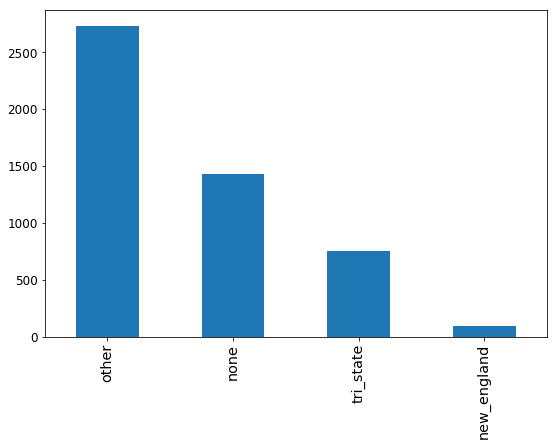

In [31]:
# Quick visualizaiton: how many tweets in each location category?
tweet_df['loc_cat'].value_counts().plot(kind='bar')

Not a lot of tweets from New England. I guess they're a little busy with their best-in-the-league team...😒

## Add in sentiment data

In [33]:
# Following: http://nealcaren.web.unc.edu/an-introduction-to-text-analysis-with-python-part-3/
# Read in lists of positive and negative words from Wilson et al.'s MPQA corpus (http://mpqa.cs.pitt.edu/)
posWW = open('positiveWords_wilsonEtAl.txt').read()
negWW = open('negativeWords_wilsonEtAl.txt').read()

# split the lists into words
positive_words = posWW.split('\n')
negative_words = negWW.split('\n')

In [34]:
# Add column to count total number of words in each tweet
tweet_df['word_count'] = tweet_df['text_clean'].str.split().str.len()
tweet_df.head(5)

,bio,date,favorite_count,id,location,retweet_count,text,user,text_clean,tri_state,new_england,has_loc,loc_cat,word_count
4999,CES Boxing matchmaker and publicist / Writer f...,2018-08-31 04:00:05,0,37602850,"Providence, R.I.",0,@sofascout1 @Yankees I think this means they k...,MichaelParente,i think this means they know judge isn t comin...,False,False,True,other,11
4998,,2018-08-31 04:00:05,0,987347124357648384,"Pittsburgh, PA",4085,RT @SportsCenter: Breaking: The Yankees have a...,CaliguireLynn,breaking the yankees have agreed to a trade f...,False,False,True,other,17
4997,https://t.co/9DJwqM1n69,2018-08-31 04:00:05,0,2992775630,"New Orleans, LA",1,RT @_TDaggs: The Yankees getting even more cop,dalekepp,tdaggs the yankees getting even more cop,False,False,True,other,7
4992,sam makes me feel special,2018-08-31 04:00:06,1,3247533025,Samantha,0,hold up yankees just got McCutchen? it’s lit!,astrowoorld,hold up yankees just got mccutchen it s lit,False,False,True,other,9
4993,Creator of @Deadseriousness | Jerk |,2018-08-31 04:00:06,23,355697532,Yankees Stadium,4,Yankees are never losing another game this is ...,TheLesterLee,yankees are never losing another game this is ...,False,False,True,other,21


## ----A problem to be fixed!----
Right now our cleaning procedure has removed apostrophes in contractions (e.g. he's --> he s). As a result, we're getting an extra count in the word count. Maybe we shouldn't remove them in these cases, or maybe we should remove the white space that results.

In [35]:
# Count the number of positive and negative words in each tweet
positive_counts = []
negative_counts = []
tweet_length = []

for tweet in tweet_df['text_clean']:
    positive_counter = 0
    negative_counter = 0
    words = tweet.split(" ")
    tweet_length.append(len(words))
    for word in words:
        if word in positive_words:
            positive_counter = positive_counter + 1
        if word in negative_words:
            negative_counter = negative_counter + 1
    positive_counts.append(positive_counter)
    negative_counts.append(negative_counter) 

## ----An exercise----
There is probably a faster, vectorized way to accomplish the above that does not rely on a for loop.. The apply() function may come in handy.

In [36]:
# Add those counts to our data frame
tweet_df['pos_count'] = positive_counts
tweet_df['neg_count'] = negative_counts

In [37]:
# Calculate ratios (what proportion of the words in each tweet is positive? negative?)
tweet_df['pos_ratio'] = tweet_df['pos_count']/tweet_df['word_count']
tweet_df['neg_ratio'] = tweet_df['neg_count']/tweet_df['word_count']

In [38]:
# Check things out again
tweet_df.head(5)

,bio,date,favorite_count,id,location,retweet_count,text,user,text_clean,tri_state,new_england,has_loc,loc_cat,word_count,pos_count,neg_count,pos_ratio,neg_ratio
4999,CES Boxing matchmaker and publicist / Writer f...,2018-08-31 04:00:05,0,37602850,"Providence, R.I.",0,@sofascout1 @Yankees I think this means they k...,MichaelParente,i think this means they know judge isn t comin...,False,False,True,other,11,0,0,0.000000,0.000000
4998,,2018-08-31 04:00:05,0,987347124357648384,"Pittsburgh, PA",4085,RT @SportsCenter: Breaking: The Yankees have a...,CaliguireLynn,breaking the yankees have agreed to a trade f...,False,False,True,other,17,1,1,0.058824,0.058824
4997,https://t.co/9DJwqM1n69,2018-08-31 04:00:05,0,2992775630,"New Orleans, LA",1,RT @_TDaggs: The Yankees getting even more cop,dalekepp,tdaggs the yankees getting even more cop,False,False,True,other,7,2,1,0.285714,0.142857
4992,sam makes me feel special,2018-08-31 04:00:06,1,3247533025,Samantha,0,hold up yankees just got McCutchen? it’s lit!,astrowoorld,hold up yankees just got mccutchen it s lit,False,False,True,other,9,1,0,0.111111,0.000000
4993,Creator of @Deadseriousness | Jerk |,2018-08-31 04:00:06,23,355697532,Yankees Stadium,4,Yankees are never losing another game this is ...,TheLesterLee,yankees are never losing another game this is ...,False,False,True,other,21,1,2,0.047619,0.095238


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F3A2048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000012D93E80>], dtype=object)

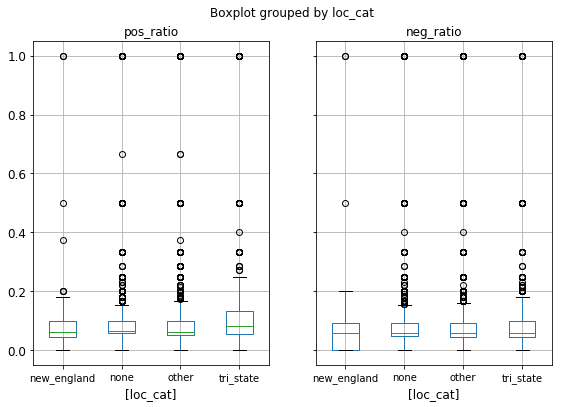

In [39]:
# Plot positive ratio as a function of region
tweet_df.boxplot(column=['pos_ratio', 'neg_ratio'], by=['loc_cat'])

### What conclusions can we infer from this plot?

On the positive ratio side, the tri-state has a slightly higher median than the others. But it also has a big range. All the regions are probably full of neutral tweets reporting scores, trades, and other news, so this is not very surprising. 

### ------

On the negative side, New England is not all that negative! Caveat that we don't have many tweets in this category, so our measure may not be that precise. 

Interestingly, the negative ratio from the Tri-State is pretty comparable to the rest of the country and to "unknowns". We could have a lot of Tri-State residents or transplants in the "other" group as well (after all, if they're tweeting about the Yankees, they probably care about the team for one reason or another.) Alternately, those lurking other-team fans in the tri-state area might make this group look more like the rest of the country than we'd expect. (But then, why would they be tweeting about the Yankees?)

Lots more to investigate here!

In [40]:
# save data once it's processed
tweet_df.to_csv('tweets_yankees_df.csv',  encoding='utf-8')